<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

**Признаки**
- `RowNumber` — индекс строки в данных
- `CustomerId` — уникальный идентификатор клиента
- `Surname` — фамилия
- `CreditScore` — кредитный рейтинг
- `Geography` — страна проживания
- `Gender` — пол
- `Age` — возраст
- `Tenure` — сколько лет человек является клиентом банка
- `Balance` — баланс на счёте
- `NumOfProducts` — количество продуктов банка, используемых клиентом
- `HasCrCard` — наличие кредитной карты
- `IsActiveMember` — активность клиента
- `EstimatedSalary` — предполагаемая зарплата

**Целевой признак**
- `Exited` — факт ухода клиента

## Подготовка данных

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.dummy import DummyClassifier

from sklearn.metrics import f1_score, roc_curve, roc_auc_score, accuracy_score

In [9]:
!pip install scikit-learn==1.1.3

In [10]:
#загружаем данные в data
data = pd.read_csv('Churn.csv')

In [11]:
#посмотрим на первые 5 строк data
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [12]:
#изучим информацию о data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Заметим, что есть пропуски в ожном из столбцов - `Tenure`, обработаем их. 

In [13]:
#посмотрим на тип данных столбца
data['Tenure'].dtype

dtype('float64')

In [14]:
#посмотрим на уникальные значения столбца
data['Tenure'].unique()

array([ 2.,  1.,  8.,  7.,  4.,  6.,  3., 10.,  5.,  9.,  0., nan])

In [15]:
#заменим пропущенные значения медианой
data['Tenure'] = data['Tenure'].fillna(data['Tenure'].median())

In [16]:
#проверим наличие пропусков
data['Tenure'].isna().sum()

0

Кажется, этот признак может быть только целым, заменим тип.

In [17]:
#заменяем тип столбца на int
data['Tenure'] = data['Tenure'].astype('int')

In [18]:
#посморти на количество дубликатов
data.duplicated().sum()

0

Кажется, что некоторые столбцы не помогут в анализе (`RowNumber`, `CustomerId`, `Surname`), удалим их.

In [19]:
#удаляем столбцы
data = data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

In [20]:
#посмотрим на обновленный data
data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [21]:
#разделим данные на признаки и целевой признак
features = data.drop(['Exited'], axis=1)
target = data['Exited']

#разделим данные на обучающую, валидационную и тестовую выборки
features_train, features_valid_test, target_train, target_valid_test = \
train_test_split(features, target, test_size=0.4, random_state=12345)

features_valid, features_test, target_valid, target_test = \
train_test_split(features_valid_test, target_valid_test, test_size=0.5, random_state=12345)

Обработаем качественные признаки

In [22]:
#применяем One Hot Encoder для качественных признаков
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
columns = ['Geography', 'Gender']
encoder_ohe.fit(features_train[columns])

features_train[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_train[columns])

features_train = features_train.drop(columns, axis=1)

features_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
7479,567,35,8,153137.74,1,1,0,88659.07,0.0,1.0,1.0
3411,711,37,8,113899.92,1,0,0,80215.20,0.0,0.0,0.0
6027,850,44,3,140393.65,2,0,1,186285.52,1.0,0.0,1.0
1247,512,24,6,0.00,2,1,0,37654.31,0.0,0.0,1.0
3716,665,27,2,147435.96,1,0,0,187508.06,1.0,0.0,0.0


In [23]:
features_valid[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_valid[columns])

features_valid = features_valid.drop(columns, axis=1)

features_valid.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
8532,585,35,2,0.00,2,1,0,98621.04,0.0,0.0,0.0
5799,625,45,3,0.00,1,1,1,184474.15,0.0,0.0,0.0
5511,667,32,0,103846.65,1,1,0,20560.69,1.0,0.0,1.0
7365,568,36,10,153610.61,1,1,1,54083.80,0.0,1.0,0.0
7367,606,42,10,0.00,2,1,0,177938.52,0.0,1.0,1.0


In [24]:
features_test[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_test[columns])

features_test = features_test.drop(columns, axis=1)

features_test.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
7041,438,38,2,0.00,2,1,0,136859.55,0.0,0.0,1.0
5709,644,39,9,0.00,1,1,0,3740.93,0.0,0.0,0.0
7117,564,31,5,121461.87,1,1,1,20432.09,0.0,1.0,1.0
7775,628,40,10,0.00,2,1,0,103832.58,0.0,1.0,1.0
8735,728,30,10,114835.43,1,0,1,37662.49,0.0,0.0,1.0


In [25]:
#масштабируем количественные признаки
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 
              'EstimatedSalary']

scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])

In [26]:
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

***Вывод:*** Всего в данных содержится 10 000 строк и 14 столбцов. Была проведена первичная обработка данных, а именно обработаны пропуски и столбцы, не содержащие важной информации. В результате данные были разделены на обучающую, валидационную и тестовую выборки (60%, 20%, 20% соответственно). Кроме того, данные были масштабированы, качественные признаки были обработаны и преобразованы в количественные.

## Исследование задачи

In [27]:
#поссмотрим на распределение классов целевого признака
target_train.value_counts(normalize=True)

0    0.800667
1    0.199333
Name: Exited, dtype: float64

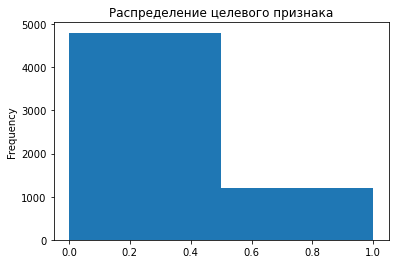

In [28]:
target_train.plot(kind='hist', bins=2)
plt.title('Распределение целевого признака');

Заметен сильный дисбаланс классов в пользу класса 0

**Random Forest Classifier**

In [29]:
#обучим модель случайного леса на несбалансированных данных
best_score = 0
best_depth = 0
best_estimator = 0
best_model_rf = None
for estimator in range(10, 101, 5):
    for depth in range(1, 31):
        model = RandomForestClassifier(n_estimators=estimator, max_depth=depth, random_state=12345)
        model.fit(features_train, target_train)
        predictions = model.predict(features_valid)
        score = f1_score(target_valid, predictions)
        print(f'max depth: {depth} ___ estimator: {estimator} F1 score: {score}')
        if best_score < score:
            best_score = score
            best_depth = depth
            best_estimator = estimator
            best_model_rf = model

max depth: 1 ___ estimator: 10 F1 score: 0.0
max depth: 2 ___ estimator: 10 F1 score: 0.2
max depth: 3 ___ estimator: 10 F1 score: 0.25102880658436216
max depth: 4 ___ estimator: 10 F1 score: 0.49578414839797635
max depth: 5 ___ estimator: 10 F1 score: 0.5170731707317073
max depth: 6 ___ estimator: 10 F1 score: 0.5475409836065573
max depth: 7 ___ estimator: 10 F1 score: 0.5625965996908809
max depth: 8 ___ estimator: 10 F1 score: 0.550314465408805
max depth: 9 ___ estimator: 10 F1 score: 0.5809379727685325
max depth: 10 ___ estimator: 10 F1 score: 0.5891238670694864
max depth: 11 ___ estimator: 10 F1 score: 0.5773195876288659
max depth: 12 ___ estimator: 10 F1 score: 0.5731166912850812
max depth: 13 ___ estimator: 10 F1 score: 0.5638766519823789
max depth: 14 ___ estimator: 10 F1 score: 0.5834542815674891
max depth: 15 ___ estimator: 10 F1 score: 0.5688888888888889
max depth: 16 ___ estimator: 10 F1 score: 0.552129221732746
max depth: 17 ___ estimator: 10 F1 score: 0.5542521994134898
ma

max depth: 18 ___ estimator: 30 F1 score: 0.582701062215478
max depth: 19 ___ estimator: 30 F1 score: 0.5765765765765767
max depth: 20 ___ estimator: 30 F1 score: 0.5498489425981874
max depth: 21 ___ estimator: 30 F1 score: 0.5598802395209581
max depth: 22 ___ estimator: 30 F1 score: 0.5714285714285715
max depth: 23 ___ estimator: 30 F1 score: 0.5802650957290133
max depth: 24 ___ estimator: 30 F1 score: 0.5744047619047619
max depth: 25 ___ estimator: 30 F1 score: 0.5714285714285715
max depth: 26 ___ estimator: 30 F1 score: 0.5714285714285715
max depth: 27 ___ estimator: 30 F1 score: 0.5714285714285715
max depth: 28 ___ estimator: 30 F1 score: 0.5714285714285715
max depth: 29 ___ estimator: 30 F1 score: 0.5714285714285715
max depth: 30 ___ estimator: 30 F1 score: 0.5714285714285715
max depth: 1 ___ estimator: 35 F1 score: 0.0
max depth: 2 ___ estimator: 35 F1 score: 0.17391304347826086
max depth: 3 ___ estimator: 35 F1 score: 0.23012552301255226
max depth: 4 ___ estimator: 35 F1 score: 

max depth: 5 ___ estimator: 55 F1 score: 0.48370497427101194
max depth: 6 ___ estimator: 55 F1 score: 0.5373134328358209
max depth: 7 ___ estimator: 55 F1 score: 0.5615141955835962
max depth: 8 ___ estimator: 55 F1 score: 0.5718849840255591
max depth: 9 ___ estimator: 55 F1 score: 0.5691823899371069
max depth: 10 ___ estimator: 55 F1 score: 0.5612403100775193
max depth: 11 ___ estimator: 55 F1 score: 0.56656346749226
max depth: 12 ___ estimator: 55 F1 score: 0.5753424657534246
max depth: 13 ___ estimator: 55 F1 score: 0.5714285714285714
max depth: 14 ___ estimator: 55 F1 score: 0.5740181268882175
max depth: 15 ___ estimator: 55 F1 score: 0.5735963581183612
max depth: 16 ___ estimator: 55 F1 score: 0.5787106446776611
max depth: 17 ___ estimator: 55 F1 score: 0.5752608047690015
max depth: 18 ___ estimator: 55 F1 score: 0.5770392749244713
max depth: 19 ___ estimator: 55 F1 score: 0.582089552238806
max depth: 20 ___ estimator: 55 F1 score: 0.5722801788375559
max depth: 21 ___ estimator: 55

max depth: 22 ___ estimator: 75 F1 score: 0.5773809523809523
max depth: 23 ___ estimator: 75 F1 score: 0.5791044776119403
max depth: 24 ___ estimator: 75 F1 score: 0.5790251107828656
max depth: 25 ___ estimator: 75 F1 score: 0.5833333333333334
max depth: 26 ___ estimator: 75 F1 score: 0.5833333333333334
max depth: 27 ___ estimator: 75 F1 score: 0.5833333333333334
max depth: 28 ___ estimator: 75 F1 score: 0.5833333333333334
max depth: 29 ___ estimator: 75 F1 score: 0.5833333333333334
max depth: 30 ___ estimator: 75 F1 score: 0.5833333333333334
max depth: 1 ___ estimator: 80 F1 score: 0.0
max depth: 2 ___ estimator: 80 F1 score: 0.12975391498881433
max depth: 3 ___ estimator: 80 F1 score: 0.23060796645702306
max depth: 4 ___ estimator: 80 F1 score: 0.38733705772811916
max depth: 5 ___ estimator: 80 F1 score: 0.48370497427101194
max depth: 6 ___ estimator: 80 F1 score: 0.533112582781457
max depth: 7 ___ estimator: 80 F1 score: 0.5650793650793651
max depth: 8 ___ estimator: 80 F1 score: 0.

max depth: 9 ___ estimator: 100 F1 score: 0.5606299212598426
max depth: 10 ___ estimator: 100 F1 score: 0.5692068429237946
max depth: 11 ___ estimator: 100 F1 score: 0.5701078582434514
max depth: 12 ___ estimator: 100 F1 score: 0.5878787878787878
max depth: 13 ___ estimator: 100 F1 score: 0.5731707317073171
max depth: 14 ___ estimator: 100 F1 score: 0.5787106446776611
max depth: 15 ___ estimator: 100 F1 score: 0.5838323353293413
max depth: 16 ___ estimator: 100 F1 score: 0.5791044776119403
max depth: 17 ___ estimator: 100 F1 score: 0.5799701046337816
max depth: 18 ___ estimator: 100 F1 score: 0.5630769230769231
max depth: 19 ___ estimator: 100 F1 score: 0.5864661654135339
max depth: 20 ___ estimator: 100 F1 score: 0.5855855855855856
max depth: 21 ___ estimator: 100 F1 score: 0.5779122541603631
max depth: 22 ___ estimator: 100 F1 score: 0.5787106446776611
max depth: 23 ___ estimator: 100 F1 score: 0.5731523378582202
max depth: 24 ___ estimator: 100 F1 score: 0.5671641791044776
max depth

In [30]:
#выведем лучшее значение f1 score
print(f'Best f1 score: {best_score} when max depth = {best_depth} and estimator = {best_estimator}')

Best f1 score: 0.5941176470588235 when max depth = 14 and estimator = 15


**Desicion Tree Classifier**

In [31]:
#обучим модель дерева решений на несбалансированных данных
best_score = 0
best_depth = 0
best_model_dt = None
for depth in range(2, 52):
    model = DecisionTreeClassifier(max_depth=depth, random_state=12345)
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    score = f1_score(target_valid, predictions)
    print(f'max depth: {depth} ___ F1 score: {score}')
    if best_score < score:
        best_score = score
        best_depth = depth
        best_model_dt = model

print(f'\nBest f1 score: {best_score} when max depth = {best_depth}')

max depth: 2 ___ F1 score: 0.5217391304347825
max depth: 3 ___ F1 score: 0.4234875444839857
max depth: 4 ___ F1 score: 0.5528700906344411
max depth: 5 ___ F1 score: 0.5406249999999999
max depth: 6 ___ F1 score: 0.5696969696969697
max depth: 7 ___ F1 score: 0.5320813771517998
max depth: 8 ___ F1 score: 0.5454545454545454
max depth: 9 ___ F1 score: 0.5633802816901409
max depth: 10 ___ F1 score: 0.5385694249649369
max depth: 11 ___ F1 score: 0.5059920106524634
max depth: 12 ___ F1 score: 0.521072796934866
max depth: 13 ___ F1 score: 0.5038961038961038
max depth: 14 ___ F1 score: 0.48675914249684743
max depth: 15 ___ F1 score: 0.4975124378109453
max depth: 16 ___ F1 score: 0.4987654320987654
max depth: 17 ___ F1 score: 0.4767726161369193
max depth: 18 ___ F1 score: 0.48522167487684725
max depth: 19 ___ F1 score: 0.49521531100478466
max depth: 20 ___ F1 score: 0.5006075334143378
max depth: 21 ___ F1 score: 0.4981949458483754
max depth: 22 ___ F1 score: 0.5006045949214026
max depth: 23 ___ F

**Logistic Regression Classifier**

In [32]:
#обучим модель логистической регрессии на несбалансированных данных
model_lr = LogisticRegression(random_state=12345)
model_lr.fit(features_train, target_train)
predictions = model_lr.predict(features_valid)

print(f'F1 score: {f1_score(target_valid, predictions)}') 

F1 score: 0.33108108108108103


In [33]:
#вычислим вероятности положительных классов
dt_probabilities_one_valid = best_model_dt.predict_proba(features_valid)[:, 1]
rf_probabilities_one_valid = best_model_rf.predict_proba(features_valid)[:, 1]
lr_probabilities_one_valid = model_lr.predict_proba(features_valid)[:, 1]

In [34]:
#вычислим roc auc score
auc_roc_dt = roc_auc_score(target_valid, dt_probabilities_one_valid)
auc_roc_rf = roc_auc_score(target_valid, rf_probabilities_one_valid)
auc_roc_lr = roc_auc_score(target_valid, lr_probabilities_one_valid)

print(f'ROC AUC for Decision Tree: {auc_roc_dt}')
print(f'ROC AUC for Random Forest: {auc_roc_rf}')
print(f'ROC AUC for Logistic Regression: {auc_roc_lr}')

ROC AUC for Decision Tree: 0.8164631712023421
ROC AUC for Random Forest: 0.8313162733866042
ROC AUC for Logistic Regression: 0.7587134570134104


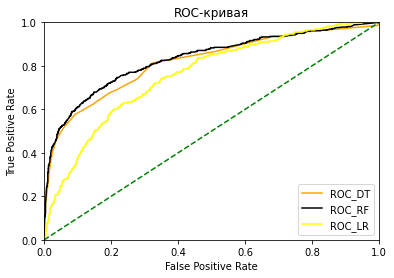

In [35]:
#построим ROC-кривую
dt_fper, dt_tper, dt_thresholds = roc_curve(target_valid, dt_probabilities_one_valid)
rf_fper, rf_tper, rf_thresholds = roc_curve(target_valid, rf_probabilities_one_valid)
lr_fper, lr_tper, lr_thresholds = roc_curve(target_valid, lr_probabilities_one_valid)

plt.plot(dt_fper, dt_tper, color='orange', label='ROC_DT')
plt.plot(rf_fper, rf_tper, color='black', label='ROC_RF')
plt.plot(lr_fper, lr_tper, color='yellow', label='ROC_LR')
plt.plot([0, 1], [0, 1], color='green', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend()
plt.show()

***Вывод:*** при обучение моделей на данных с дисбалансом моделью с лучшим показателем f1 score на валидационной выборке (0.59) стала Random Forest Classifier. Также эта модель показала лучшее значение ROC AUC (0.83).

## Борьба с дисбалансом

Как мы выяснили ранее в нашей выборке отрицательны ответов ≈ 80% , положитительных ≈ 20%. Нам необходмо увеличить количество положительных ответов в 4 раза для достижения баланса. Либо же уменьшить кол-во отрицательных ответов.

Попробуем воспользоваться `class_weight='balanced'`

In [36]:
#обучим модель случайного леса на сбалансированных данных
best_score = 0
best_depth = 0
best_estimator = 0
best_model_rf = None
for estimator in range(10, 121, 10):
    for depth in range(1, 21):
        model = RandomForestClassifier(n_estimators=estimator, max_depth=depth, 
                                       class_weight='balanced', random_state=12345)
        model.fit(features_train, target_train)
        predictions = model.predict(features_valid)
        score = f1_score(target_valid, predictions)
        print(f'max depth: {depth} ___ estimator: {estimator} F1 score: {score}')
        if best_score < score:
            best_score = score
            best_depth = depth
            best_estimator = estimator
            best_model_rf = model

max depth: 1 ___ estimator: 10 F1 score: 0.5159165751920967
max depth: 2 ___ estimator: 10 F1 score: 0.569620253164557
max depth: 3 ___ estimator: 10 F1 score: 0.5668849391955099
max depth: 4 ___ estimator: 10 F1 score: 0.5989637305699482
max depth: 5 ___ estimator: 10 F1 score: 0.5916334661354582
max depth: 6 ___ estimator: 10 F1 score: 0.6071428571428573
max depth: 7 ___ estimator: 10 F1 score: 0.6078838174273858
max depth: 8 ___ estimator: 10 F1 score: 0.6225596529284164
max depth: 9 ___ estimator: 10 F1 score: 0.6087912087912088
max depth: 10 ___ estimator: 10 F1 score: 0.6060606060606061
max depth: 11 ___ estimator: 10 F1 score: 0.5895522388059701
max depth: 12 ___ estimator: 10 F1 score: 0.5802310654685494
max depth: 13 ___ estimator: 10 F1 score: 0.5782493368700264
max depth: 14 ___ estimator: 10 F1 score: 0.5798319327731092
max depth: 15 ___ estimator: 10 F1 score: 0.5684830633284241
max depth: 16 ___ estimator: 10 F1 score: 0.5419734904270986
max depth: 17 ___ estimator: 10 F1

max depth: 17 ___ estimator: 70 F1 score: 0.5739910313901345
max depth: 18 ___ estimator: 70 F1 score: 0.5762195121951219
max depth: 19 ___ estimator: 70 F1 score: 0.5792682926829268
max depth: 20 ___ estimator: 70 F1 score: 0.558282208588957
max depth: 1 ___ estimator: 80 F1 score: 0.5387453874538745
max depth: 2 ___ estimator: 80 F1 score: 0.5753931544865866
max depth: 3 ___ estimator: 80 F1 score: 0.5835641735918744
max depth: 4 ___ estimator: 80 F1 score: 0.6063522617901829
max depth: 5 ___ estimator: 80 F1 score: 0.6110019646365422
max depth: 6 ___ estimator: 80 F1 score: 0.6156982670744139
max depth: 7 ___ estimator: 80 F1 score: 0.6176470588235294
max depth: 8 ___ estimator: 80 F1 score: 0.6172300981461287
max depth: 9 ___ estimator: 80 F1 score: 0.6229885057471264
max depth: 10 ___ estimator: 80 F1 score: 0.6137184115523466
max depth: 11 ___ estimator: 80 F1 score: 0.602258469259724
max depth: 12 ___ estimator: 80 F1 score: 0.6045272969374168
max depth: 13 ___ estimator: 80 F1 

In [37]:
#выведем лучшее значение f1 score
print(f'Best f1 score: {best_score} when max depth = {best_depth} and estimator = {best_estimator}')

Best f1 score: 0.6291618828932262 when max depth = 9 and estimator = 110


In [38]:
#обучим модель дерева решений на сбалансированных данных
best_score = 0
best_depth = 0
best_model_dt = None
for depth in range(1, 21):
    model = DecisionTreeClassifier(max_depth=depth, class_weight='balanced', random_state=12345)
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    score = f1_score(target_valid, predictions)
    print(f'max depth: {depth} ___ F1 score: {score}')
    if best_score < score:
        best_score = score
        best_depth = depth
        best_model_dt = model

print(f'\nBest f1 score: {best_score} when max depth = {best_depth}')

max depth: 1 ___ F1 score: 0.4994903160040775
max depth: 2 ___ F1 score: 0.541015625
max depth: 3 ___ F1 score: 0.541015625
max depth: 4 ___ F1 score: 0.5277777777777778
max depth: 5 ___ F1 score: 0.5963791267305644
max depth: 6 ___ F1 score: 0.5581835383159887
max depth: 7 ___ F1 score: 0.5508390918065154
max depth: 8 ___ F1 score: 0.5398058252427185
max depth: 9 ___ F1 score: 0.5431119920713577
max depth: 10 ___ F1 score: 0.5081495685522531
max depth: 11 ___ F1 score: 0.533748701973001
max depth: 12 ___ F1 score: 0.5035677879714576
max depth: 13 ___ F1 score: 0.5151515151515152
max depth: 14 ___ F1 score: 0.4872080088987764
max depth: 15 ___ F1 score: 0.47861271676300576
max depth: 16 ___ F1 score: 0.49114521841794573
max depth: 17 ___ F1 score: 0.4940617577197149
max depth: 18 ___ F1 score: 0.47971360381861583
max depth: 19 ___ F1 score: 0.47961630695443647
max depth: 20 ___ F1 score: 0.4852941176470588

Best f1 score: 0.5963791267305644 when max depth = 5


In [39]:
#попробуем обучить модели со сбалансированными классами
model_lr_balanced = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
model_lr_balanced.fit(features_train, target_train)
predictions = model_lr_balanced.predict(features_valid)

print(f'F1 score: {f1_score(target_valid, predictions)}') 

F1 score: 0.4888507718696398


Значение f1 score немного увеличилось, попробуем дальше.

In [40]:
#создадим функцию upsample для увеличения положительного класса
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

In [41]:
#применим функцию к обучающей выборке
features_train_upsampled, target__train_upsampled = upsample(features_train, target_train, 4)
print(target__train_upsampled.value_counts(normalize=True))

0    0.501043
1    0.498957
Name: Exited, dtype: float64


In [42]:
#создадим функцию для уменьшения класса 0 в выборке 
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

In [43]:
#применим функцию к обучающей выборке
features_train_downsampled, target_train_downsampled = downsample(features_train, target_train, 0.25)
print(target_train_downsampled.value_counts(normalize=True))

0    0.501043
1    0.498957
Name: Exited, dtype: float64


In [44]:
#обучим модель случайного леса на сбалансированных данных
best_score = 0
best_depth = 0
best_estimator = 0
best_model_rf = None
for estimator in range(10, 121, 10):
    for depth in range(1, 21):
        model = RandomForestClassifier(n_estimators=estimator, max_depth=depth, 
                                       class_weight='balanced', random_state=12345)
        model.fit(features_train_upsampled, target__train_upsampled)
        predictions = model.predict(features_valid)
        score = f1_score(target_valid, predictions)
        print(f'max depth: {depth} ___ estimator: {estimator} F1 score: {score}')
        if best_score < score:
            best_score = score
            best_depth = depth
            best_estimator = estimator
            best_model_rf = model

max depth: 1 ___ estimator: 10 F1 score: 0.5159165751920967
max depth: 2 ___ estimator: 10 F1 score: 0.5766129032258065
max depth: 3 ___ estimator: 10 F1 score: 0.5792972459639126
max depth: 4 ___ estimator: 10 F1 score: 0.606
max depth: 5 ___ estimator: 10 F1 score: 0.6050583657587548
max depth: 6 ___ estimator: 10 F1 score: 0.5948026948989412
max depth: 7 ___ estimator: 10 F1 score: 0.5962487660414609
max depth: 8 ___ estimator: 10 F1 score: 0.6038894575230296
max depth: 9 ___ estimator: 10 F1 score: 0.5908629441624366
max depth: 10 ___ estimator: 10 F1 score: 0.5995717344753747
max depth: 11 ___ estimator: 10 F1 score: 0.588235294117647
max depth: 12 ___ estimator: 10 F1 score: 0.5860889395667047
max depth: 13 ___ estimator: 10 F1 score: 0.592857142857143
max depth: 14 ___ estimator: 10 F1 score: 0.5973397823458283
max depth: 15 ___ estimator: 10 F1 score: 0.5778331257783312
max depth: 16 ___ estimator: 10 F1 score: 0.5900383141762451
max depth: 17 ___ estimator: 10 F1 score: 0.5684

max depth: 17 ___ estimator: 70 F1 score: 0.5961290322580646
max depth: 18 ___ estimator: 70 F1 score: 0.6062992125984252
max depth: 19 ___ estimator: 70 F1 score: 0.596078431372549
max depth: 20 ___ estimator: 70 F1 score: 0.6026315789473685
max depth: 1 ___ estimator: 80 F1 score: 0.5412186379928317
max depth: 2 ___ estimator: 80 F1 score: 0.5637342908438061
max depth: 3 ___ estimator: 80 F1 score: 0.5790441176470589
max depth: 4 ___ estimator: 80 F1 score: 0.5954198473282444
max depth: 5 ___ estimator: 80 F1 score: 0.5994123408423115
max depth: 6 ___ estimator: 80 F1 score: 0.6137040714995033
max depth: 7 ___ estimator: 80 F1 score: 0.613682092555332
max depth: 8 ___ estimator: 80 F1 score: 0.6161719549641761
max depth: 9 ___ estimator: 80 F1 score: 0.6139438085327783
max depth: 10 ___ estimator: 80 F1 score: 0.6229508196721312
max depth: 11 ___ estimator: 80 F1 score: 0.626865671641791
max depth: 12 ___ estimator: 80 F1 score: 0.6173708920187794
max depth: 13 ___ estimator: 80 F1 s

In [45]:
print(f'Best f1 score: {best_score} when max depth = {best_depth} and estimator = {best_estimator}')

rf_probabilities_one_valid = best_model_rf.predict_proba(features_valid)[:, 1]
auc_roc_rf = roc_auc_score(target_valid, rf_probabilities_one_valid)

print(f'ROC AUC for Random Forest: {auc_roc_rf}')

Best f1 score: 0.6285714285714286 when max depth = 11 and estimator = 90
ROC AUC for Random Forest: 0.8502697814528274


In [46]:
#обучим модель дерева решений на сбалансированных данных
best_score = 0
best_depth = 0
best_model_dt = None
for depth in range(1, 21):
    model = DecisionTreeClassifier(max_depth=depth, class_weight='balanced', random_state=12345)
    model.fit(features_train_upsampled, target__train_upsampled)
    predictions = model.predict(features_valid)
    score = f1_score(target_valid, predictions)
    print(f'max depth: {depth} ___ F1 score: {score}')
    if best_score < score:
        best_score = score
        best_depth = depth
        best_model_dt = model

print(f'\nBest f1 score: {best_score} when max depth = {best_depth}')

dt_probabilities_one_valid = best_model_dt.predict_proba(features_valid)[:, 1]
auc_roc_dt = roc_auc_score(target_valid, dt_probabilities_one_valid)

print(f'ROC AUC for Decision Tree: {auc_roc_dt}')

max depth: 1 ___ F1 score: 0.4994903160040775
max depth: 2 ___ F1 score: 0.541015625
max depth: 3 ___ F1 score: 0.541015625
max depth: 4 ___ F1 score: 0.5277777777777778
max depth: 5 ___ F1 score: 0.5963791267305644
max depth: 6 ___ F1 score: 0.5581835383159887
max depth: 7 ___ F1 score: 0.5496031746031745
max depth: 8 ___ F1 score: 0.5346341463414634
max depth: 9 ___ F1 score: 0.5398406374501993
max depth: 10 ___ F1 score: 0.5095785440613028
max depth: 11 ___ F1 score: 0.5325077399380805
max depth: 12 ___ F1 score: 0.5174537987679672
max depth: 13 ___ F1 score: 0.5058697972251868
max depth: 14 ___ F1 score: 0.48697621744054354
max depth: 15 ___ F1 score: 0.4900351699882767
max depth: 16 ___ F1 score: 0.4904306220095694
max depth: 17 ___ F1 score: 0.4878640776699029
max depth: 18 ___ F1 score: 0.4932844932844933
max depth: 19 ___ F1 score: 0.47911547911547914
max depth: 20 ___ F1 score: 0.4920049200492005

Best f1 score: 0.5963791267305644 when max depth = 5
ROC AUC for Decision Tree: 

In [47]:
#обучим модель Logistic Regression на сбалансированных данных
model_lr = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
model_lr.fit(features_train_upsampled, target__train_upsampled)
predictions = model_lr.predict(features_valid)
score = f1_score(target_valid, predictions)
print(f'F1 score: {score}')

lr_probabilities_one_valid = model_lr.predict_proba(features_valid)[:, 1]
auc_roc_lr = roc_auc_score(target_valid, lr_probabilities_one_valid)

print(f'ROC AUC for Logistic Regression: {auc_roc_lr}')

F1 score: 0.4888507718696398
ROC AUC for Logistic Regression: 0.7635888796811015


***Вывод:*** после модификаций с балансом классов значения увеличились; модель с лучшими показателями f1 score и ROC AUC score - Random Forest (0.63 и 0.85 соответственно). Для борьбы с дисбалансом использовался метод upsampling, то есть увеличение положительного класса.
<br>Гиперпараметры лучшей модели:
- max_depth = 11 
- n_estimators = 90

## Тестирование модели

In [48]:
#тестирование Random Forest
predictions = best_model_rf.predict(features_test)
score = f1_score(target_test, predictions)

rf_probabilities_one_test = best_model_rf.predict_proba(features_test)[:, 1]
auc_roc_rf = roc_auc_score(target_test, rf_probabilities_one_test)

print(f'\nROC AUC for Random Forest: {auc_roc_rf}')

#создаем константную модель
target_predict_constant = pd.Series([1]*len(target_test))
auc_roc_const = roc_auc_score(target_test, target_predict_constant)
print(f'ROC AUC for const: {auc_roc_const}')

dummy_model = DummyClassifier(strategy='constant', constant=1)
dummy_model.fit(features_train, target_train)

print(f'\nF1 score for Random Forest: {score}')
print(f'F1 score for const: {f1_score(dummy_model.predict(features_test), target_test)}')


ROC AUC for Random Forest: 0.8560138276135523
ROC AUC for const: 0.5

F1 score for Random Forest: 0.6105499438832772
F1 score for const: 0.3491539413949649


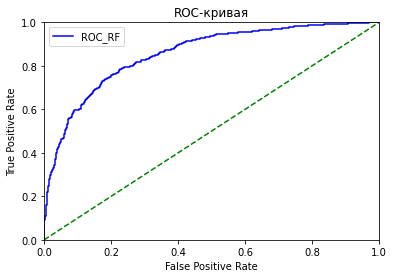

In [49]:
#построим ROC-кривую
rf_fper, rf_tper, rf_thresholds = roc_curve(target_test, rf_probabilities_one_test)

plt.plot(rf_fper, rf_tper, color='blue', label='ROC_RF')
plt.plot([0, 1], [0, 1], color='green', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend()
plt.show()

***Вывод:*** показатели на тестовой выборке: 
- F1 score - 0.61
- ROC AUC - 0.86
<br>Кроме того, модель показывает значения лучше константной, значит можно считать модель адекватной

**Общий вывод**
<br>В исходных данных наблюдался значительный дисбаланс (80% ответов по целевым признакам были отрицательными и только 20% положительными), поэтому модель, обученная на этих данных, не прошла тест на адекватность. 

Воспользовавшись методом upsampling и поменяв `class_weight` на `balanced` удалось устранить дисбаланс классов, при этом увеличилось количество значений позитивного класса в 4 раза. Так мы достигли баланса классо в обучеющей выборки: 0 - 0.501043 1 - 0.498957

На новых данных все модели показали результат выше, чем на несбалансированной выборке. Лучшие показатели были у модели `Random Forest`:
- F1 score: 0.6285714285714286
- ROC AUC score: 0.8502697814528274

Финальная модель показала следующие результаты и прошла проверку на адекватность в сравнении с контантной моделью: 

- ROC AUC for Random Forest: 0.8560138276135523
- ROC AUC for const: 0.5

- F1 score for Random Forest: 0.6105499438832772
- F1 score for const: 0.3491539413949649